References:
- [Probabilistic Programming & Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers?tab=readme-ov-file)
- [Statistical Rethinking 2023](https://github.com/dustinstansbury/statistical-rethinking-2023)
- [Danielle Navarro's Blog 'The Metropolis-Hastings algorithm'](https://blog.djnavarro.net/posts/2023-04-12_metropolis-hastings/#the-problem)

`pm.Exponential()` variables are treated by the back end as random number generators.

## Priors
### Beta Distribution
Used to model Bernoulli, Binomial, or Geometric distributions.

Bounded between [0,1]. 

$ Beta(1,1) $ is a uniform distribution. 

### Gamma Distribution
Use Case: Rate parameters in Poisson or Exponential distributions; precision (inverse variance) in Normal distributions.

## Bayesian Bandits
An approximate solution to the infamous [Multi-Armed Bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(seed=42)
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
n_simulations = 10000

slot_machine_1_sims = rng.binomial(n=1, p=0.3, size=n_simulations)
slot_machine_2_sims = rng.binomial(n=1, p=0.25, size=n_simulations)
slot_machine_3_sims = rng.binomial(n=1, p=0.1, size=n_simulations)

# with pm.Model() as model:

## Detecting Change Over Time
We have data containing the count of events that occured on a given day. We want to determine if there has been an increase in events.

We start with the prior believe that the events are exponentially distributed with a mean that is equal to the observed data average. We also define a variable, $\tau$, that is uniformly distributed across each time step in the dataset. Then we sample from the observed data and update our believes and analyze the resulting distributions.  

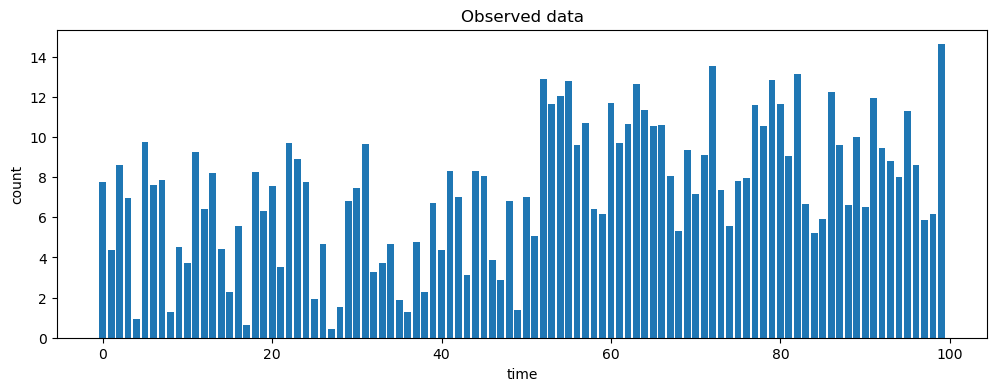

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


c:\Users\JBarker\AppData\Local\miniforge3\envs\pymc\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 50 seconds.


In [6]:
data = np.concatenate([
    rng.uniform(low=0, high=10, size=50),
    rng.uniform(low=5, high=15, size=50)
])

n = len(data)
plt.bar(np.arange(n), data)
plt.title('Observed data')
plt.ylabel('count')
plt.xlabel('time')
plt.show()

with pm.Model() as model:
    alpha = 1.0 / data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    idx = np.arange(n)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=data)

    step = pm.NUTS()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

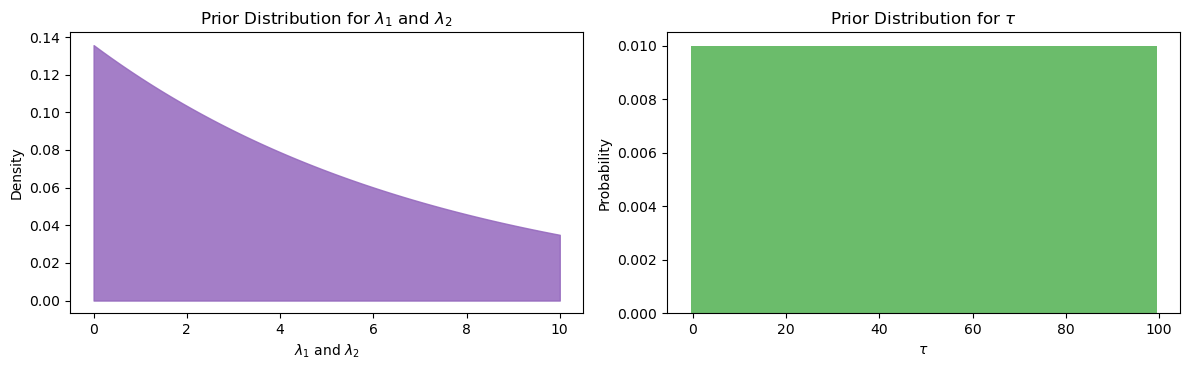

In [12]:
# Create a new figure for prior distributions
fig_prior, axes_prior = plt.subplots(1, 2)

x_values = np.linspace(0, 10, 100)
prior_lambda_1 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_1
prior_lambda_2 = (alpha * np.exp(-alpha * x_values))  # Prior distribution for lambda_2

# Plot prior for lambda_1
axes_prior[0].fill_between(x_values, prior_lambda_1, color="C4", alpha=0.85)
axes_prior[0].set_title("Prior Distribution for $\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$")
axes_prior[0].set_ylabel("Density")

# Plot prior for tau
tau_x_values = np.arange(0, n)  # Discrete values for tau
prior_tau = np.ones_like(tau_x_values) / len(tau_x_values)  # Uniform distribution
axes_prior[1].bar(tau_x_values, prior_tau, width=1, color="C2", alpha=0.7)
axes_prior[1].set_title("Prior Distribution for $\\tau$")
axes_prior[1].set_xlabel("$\\tau$")
axes_prior[1].set_ylabel("Probability")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\JBarker\AppData\Local\Temp\ipykernel_40232\4157385644.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="upper right")


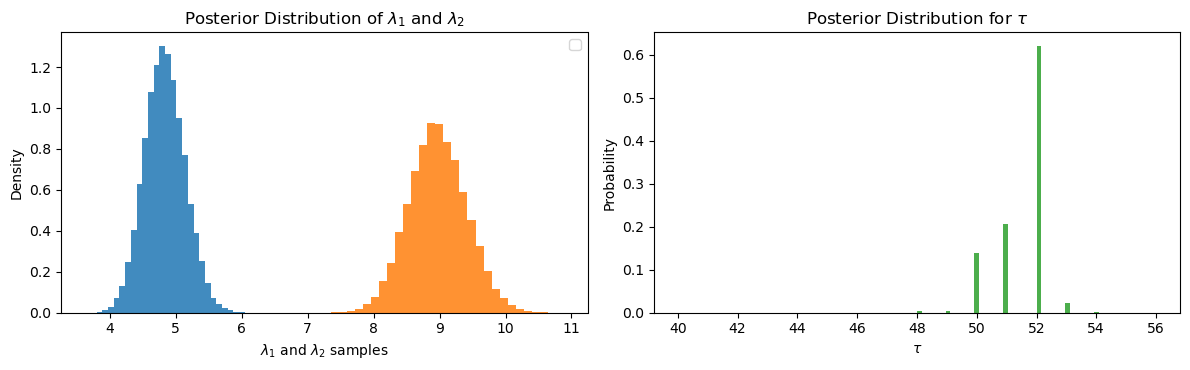

In [21]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C0", density=True)
axes[0].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="C1", density=True)
axes[0].set_xlabel("$\\lambda_1$ and $\\lambda_2$ samples")
axes[0].set_ylabel("Density")
axes[0].legend(loc="upper right")
axes[0].set_title("Posterior Distribution of $\\lambda_1$ and $\\lambda_2$")

weights=np.ones_like(tau_samples) / tau_samples.shape[0]
axes[1].hist(tau_samples, bins=n, alpha=0.85, color="C2", weights=weights)
axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Probability")
axes[1].set_title("Posterior Distribution for $\\tau$")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()